In [1]:
#%matplotlib widget
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from functools import lru_cache
import numpy as np
from scipy import ndimage

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
flatten = lambda l: [item for sublist in l for item in sublist]

def frames():
    vidcap = cv2.VideoCapture('../data/train.mp4')
    while True:
        success, image = vidcap.read()
        if success:
            yield image
        else:
            return

def crop(im, bottom=100, top=220):
    # take of top and bottom
    return im[top:im.shape[0]-bottom,:]

def tile(im, nrows=1, ncolumns=6):
    M = im.shape[0] // nrows
    N = im.shape[1] // ncolumns
    rows = []
    for y in range(0,N*ncolumns,N):
        row = []
        for x in range(0,M*nrows,M):
            row.append(im[x:x+M,y:y+N])
        rows.append(row)
    return rows

def shuffle_time_in_chunks(df, n):
    """Break df into n-lengths mini dfs"""
    assert len(df) > n*10, "doesn't meet minimum number of chunks"
    assert (len(df) % n) == 0, "all chunks equal size"
    
    chunk_count = len(df[0]) // n
    chunks = []
    for x in range(0, len(df), n):
        chunks.append(df[x:x + n])
    random.shuffle(chunks)
    return pd.concat(chunks, axis=0)

def quick_view(fs, frames_per_step=1, start=1000, stop=1010):
    for i, im in enumerate(fs):
        if not (start<i<stop):
            if i>stop:
                break
            continue
        if i % frames_per_step != 0:
            continue
        cv2.imshow('oned',im)
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            break
    cv2.destroyAllWindows()

In [3]:
def cframes():
    for im in frames():
        yield crop(im)

In [4]:
quick_view(cframes(), frames_per_step=1, start=60, stop=180)

In [6]:
# blur/focus based
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()
xs=[]
for i, f in enumerate(cframes()):
    #tiles = tile(f,8,20)
    tiles = tile(f,2,4)
    xs.append([variance_of_laplacian(i) for i in flatten(tiles)])
    if i % 1000 == 0:
        print('.', end='')

.....................

In [8]:
y = pd.read_csv('../data/train.txt', header=None)
X = pd.DataFrame(xs)

Xy = X.copy(deep=True)
Xy['y'] = y

chunksize = 240
Xy = shuffle_time_in_chunks(Xy, chunksize)

# X = Xy[X.columns]
# yorig = y
# y = Xy[['y']]
Xy

,0,1,2,3,4,5,6,7,y
19440,65.956288,17.922507,523.436859,16.830131,352.857088,19.318438,26.137771,10.508497,1.843987
19441,49.228002,16.897890,524.669031,17.936467,342.930577,18.818540,23.773724,9.973117,1.843350
19442,50.541664,15.519031,626.352309,25.914202,373.754601,20.694054,27.455567,11.553808,1.835200
19443,49.271245,12.596540,531.817158,22.834117,335.155903,19.358192,22.254486,9.358791,1.814680
19444,49.945045,12.478679,587.158666,23.963113,343.479153,19.373331,24.658396,10.208005,1.793034
...,...,...,...,...,...,...,...,...,...
10315,280.329404,31.518584,493.924262,27.983168,256.662299,37.759079,8.863543,13.630134,6.978083
10316,299.962817,36.116216,504.099883,29.859872,277.470447,37.704055,9.107230,12.823149,6.985439
10317,290.445525,33.877392,424.148856,26.271650,264.884555,36.669419,9.200719,12.739638,6.959919
10318,329.903719,22.066410,448.776958,27.399210,296.226325,42.913880,12.452725,13.146297,6.876967


In [16]:
def find_testcount(test_df, fraction_testset=0.3):
    chunks = 1
    while True:
        chunks += 1
        testcount = chunksize * chunks
        if testcount/len(test_df)>fraction_testset:
            break
    print(f"using testcount = {testcount}")
    return testcount
    
testcount = find_testcount(Xy, .43)

#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=testcount, shuffle=False)
Xy_train, Xy_test = train_test_split(Xy, test_size=testcount,shuffle=False)
Xy_train, Xy_test = Xy_train.copy(deep=True), Xy_test.copy(deep=True)
print("Percent test    =", testcount/len(Xy))

using testcount = 8880
Percent test    = 0.43529411764705883


In [17]:
m_dum = DummyRegressor(strategy='mean')

pipe = Pipeline([
        ('scale', StandardScaler()),
        #'reduce_dims', PCA(n_components=4)),
        ('svr', SVR())])

from sklearn.model_selection import GridSearchCV
parameters = {
    #'svr__C':[.01, .1, .3, .9, 2, 4, 10, 20],
    'svr__C':[10, 15, 20, 30, 40],
    #'svr__gamma':[0.006/4, 0.006/2,0.006,0.006*2],
    }
grid = GridSearchCV(pipe, parameters, verbose=10, n_jobs=7, cv=2)

#m_real = grid
m_real = grid


In [18]:
m_dum.fit(Xy_train[X.columns], Xy_train['y'])
m_real.fit(Xy_train[X.columns], Xy_train['y'])
try:
    print(m_real.best_estimator_)
except:
    print(m_real)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    4.7s remaining:   10.9s
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:    5.8s remaining:    2.5s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    8.5s finished


Pipeline(steps=[('scale', StandardScaler()), ('svr', SVR(C=10))])


In [20]:
Xy_test['dum'] = m_dum.predict(Xy_test[X.columns])
Xy_test['pred'] = m_real.predict(Xy_test[X.columns])
Xy_train['pred'] = m_real.predict(Xy_train[X.columns])
print(f"dummy test train")
print(f"{mean_squared_error(Xy_test['y'], Xy_test['dum']):0.1f} "
      f"{mean_squared_error(Xy_test['y'], Xy_test['pred']):0.1f} "
      f"{mean_squared_error(Xy_train['y'], Xy_train['pred']):0.1f}")

dummy test train
58.4 48.2 18.9


testing error, training error
- naive shuffle, mean dummy regressor = 68
- naive shuffle, 1x1x(varlaplace) tilessvr.predict(Xtest), SVR(C=?) = 44
- naive shuffle, 6x3x(varlaplace) tiles, SVR(C=30) = 19.4
- naive shuffle, 12x5x(varlaplace) tiles, SVR(C=30) = 10.3
- naive shuffle, test_size=.150, 26x12x(varlaplace) tiles, SVR(C=.2) = 17.9, 18.1
-    no shuffle, test_size=.150, 26x12x(varlaplace) tiles, SVR(C=.2) = 33.2, 17.7
- chunk shuffle, test_size=.147, 26x12x(varlaplace) tiles, SVR(C=.2) = 39, 16.6
- chunk shuffle, test_size=.147, 26x12x(varlaplace) tiles, SVR(C=.1) = 42, 20
- chunk shuffle, test_size=.147, 26x12x(varlaplace) tiles, SVR(C=.5) = 36, 12
- chunk shuffle, test_size=.147, 14x06x(varlaplace) tiles, SVR(C=.5) = 27, 19
- chunk shuffle, test_size=.147, 14x06x(varlaplace) tiles, SVR(C=.3) = 28.5, 21.5, 39.5
- chunk shuffle, test_size=.245, 14x06x(varlaplace) tiles, SVR(C=.3) = 50, 46, 18
# new crop
- chunk no shuffle, test_size=.245, 14x06x(varlaplace) tiles, SVR(C=.3) = 71, 39, 26.9
- chunk=5 shuffle, test_size=.367, 06x06x(varlaplace) tiles, SVR(C=.3) = 67, 30, 29.1
- chunk=5 shuffle, test_size=.491, 06x06x(varlaplace) tiles, SVR(C=.3) = 67, 30, 29.7
- chunk=5 shuffle, test_size=.73, 06x06x(varlaplace) tiles, SVR(C=.3) = 67, 32, 30.7

# Fixed tiler                                             
-                                                                dummy test train
- chunk=60 shuffle, test_size=.43, 4x10(varlaplace), SVR(C=.3) = 70.3 39.6 29.4
- chunk=60 shuffle, test_size=.43, 8x20(varlaplace), SVR(C=.3) = 71.6 31.1 22.6
- chunk=60 shuffle, test_size=.43, 8x20(varlaplace), gridsearch = 71.6 31.1 22.6
- chunk=60 focus 3x8 SVR(C=20, gamma=0.006) 64.0 13.0 2.0


## ideas
x start chunking
- increase test_size to at least .25
- accelleration limits based on testing set. This could be a post processing step.concat

In [21]:
Xy

,0,1,2,3,4,5,6,7,y
19440,65.956288,17.922507,523.436859,16.830131,352.857088,19.318438,26.137771,10.508497,1.843987
19441,49.228002,16.897890,524.669031,17.936467,342.930577,18.818540,23.773724,9.973117,1.843350
19442,50.541664,15.519031,626.352309,25.914202,373.754601,20.694054,27.455567,11.553808,1.835200
19443,49.271245,12.596540,531.817158,22.834117,335.155903,19.358192,22.254486,9.358791,1.814680
19444,49.945045,12.478679,587.158666,23.963113,343.479153,19.373331,24.658396,10.208005,1.793034
...,...,...,...,...,...,...,...,...,...
10315,280.329404,31.518584,493.924262,27.983168,256.662299,37.759079,8.863543,13.630134,6.978083
10316,299.962817,36.116216,504.099883,29.859872,277.470447,37.704055,9.107230,12.823149,6.985439
10317,290.445525,33.877392,424.148856,26.271650,264.884555,36.669419,9.200719,12.739638,6.959919
10318,329.903719,22.066410,448.776958,27.399210,296.226325,42.913880,12.452725,13.146297,6.876967


In [58]:
#calculate acceleration of training set over time
#use kalman filter based 

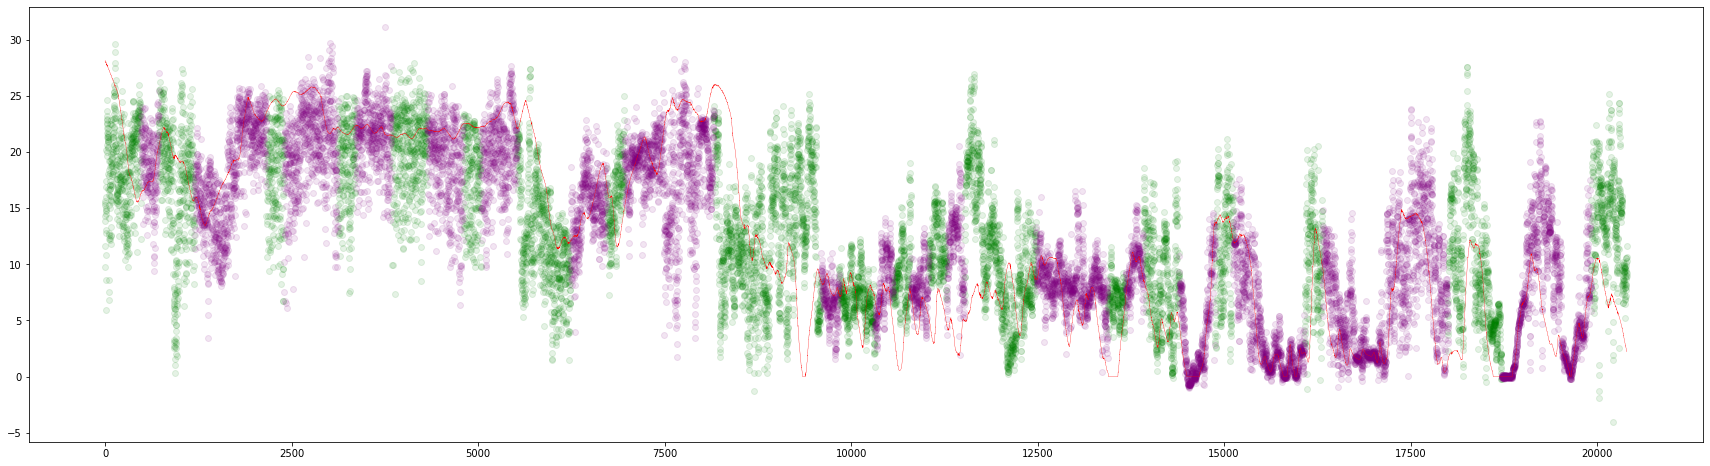

In [39]:
plt.rcParams['figure.figsize'] = [30, 8]
Xy_sorted = Xy.sort_index()
plt.plot(Xy_test.index, Xy_test['pred'].values, marker='o', linewidth=0.0, color='green', alpha=.1);
plt.plot(Xy_train.index, Xy_train['pred'].values, marker='o', linewidth=0.0, color='purple', alpha=.1);
plt.plot(Xy_sorted.index, Xy_sorted['y'].values, marker='', linewidth=0.3, color='red');
